### Preliminaries

In [1]:
# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream,fit1,fit2,params

###Load the data

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
num_subjects = 49
print('There are %d different perceptual descriptors and %d different subjects.' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects.


In [6]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have %d molecular descriptors for %d unique molecules." % \
      (len(molecular_data[0])-1,total_size))

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have 4869 molecular descriptors for 476 unique molecules.


In [7]:
# Determine the size of the training set.  
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules." % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules.
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [8]:
# Determine how many data points there, and how many of these are replicates.  
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)." % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules).


In [9]:
# Get all Chemical IDs and located the data directory.  
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
DATA = '/Users/rgerkin/Dropbox/science/olfaction-prediction/data/'
import pandas

In [10]:
# Load the Episuite features.  
episuite = pandas.read_table('%s/DREAM_episuite_descriptors.txt' % DATA)
episuite.iloc[:,49] = 1*(episuite.iloc[:,49]=='YES ')
episuite.iloc[:,49]
episuite = episuite.iloc[:,2:].as_matrix()
print("Episuite has %d features for %d molecules." % (episuite.shape[1],episuite.shape[0]))

Episuite has 62 features for 476 molecules.


In [11]:
# Load the Verbal descriptors (from chemical names).
verbal = pandas.read_table('%s/name_features.txt' % DATA, sep='\t', header=None)
verbal = verbal.as_matrix()[:,1:]
verbal.shape
print("Verbal has %d features for %d molecules." % (verbal.shape[1],verbal.shape[0]))

Verbal has 11786 features for 476 molecules.


In [12]:
# Load the Morgan features.  
morgan = pandas.read_csv('%s/morgan_sim.csv' % DATA)
morgan = morgan.as_matrix()[:,1:]
print("Morgan has %d features for %d molecules." % (morgan.shape[1],morgan.shape[0]))

Morgan has 2437 features for 476 molecules.


In [13]:
# Start to load the NSPDK features.  
with open('%s/derived/nspdk_r3_d4_unaug.svm' % DATA) as f:
    nspdk_dict = {}
    i = 0
    while True:
        x = f.readline()
        if(len(x)):
            key_vals = x.split(' ')[1:]
            for key_val in key_vals:
                key,val = key_val.split(':')
                if key in nspdk_dict:
                    nspdk_dict[key][all_CIDs[i]] = val
                else:
                    nspdk_dict[key] = {all_CIDs[i]:val}
            i+=1
            if i == len(all_CIDs):
                break
        else:
            break
nspdk_dict = {key:value for key,value in nspdk_dict.items() if len(value)>1}

In [14]:
# Get the NSPDK features into the right format.  
nspdk = np.zeros((len(all_CIDs),len(nspdk_dict)))
for j,(feature,facts) in enumerate(nspdk_dict.items()):
    for CID,value in facts.items():
        i = all_CIDs.index(CID)
        nspdk[i,j] = value
print("NSPDK has %d features for %d molecules." % (nspdk.shape[1],nspdk.shape[0]))

NSPDK has 6163 features for 476 molecules.


In [15]:
# Load the NSPDK Gramian features.  
# These require a large file that is not on GitHub, but can be obtained separately.  
nspdk_gramian = pandas.read_table('%s/derived/nspdk_r3_d4_unaug_gramian.mtx' % DATA, delimiter=' ', header=None)
nspdk_gramian = nspdk_gramian.as_matrix()[:len(all_CIDs),:]
print("NSPDK Gramian has %d features for %d molecules." % \
      (nspdk_gramian.shape[1],nspdk_gramian.shape[0]))

NSPDK Gramian has 2437 features for 476 molecules.


In [16]:
# Add all these new features to the molecular data dict.  
molecular_data_extended = molecular_data.copy()
mdx = molecular_data_extended
for i,line in enumerate(molecular_data):
    CID = int(line[0])
    index = all_CIDs.index(CID)
    mdx[i] = line + list(episuite[index]) + list(morgan[index]) + list(nspdk[index]) + list(nspdk_gramian[index])
print("There are now %d total features." % (len(mdx[0])-1))

There are now 15968 total features.


In [17]:
4869+62+2437+6163+2437

15968

### Create matrices

In [18]:
# Create the feature matrices from the feature dicts.  
X_training,good1,good2,means,stds,imputer = dream.make_X(mdx,"training")
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(mdx,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(mdx,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(mdx,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(mdx,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_all,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (676x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x13914) molecules by non-NaN good molecular descriptors


In [19]:
# Create descriptor matrices for the training set.  
# One is done with median imputation, and the other by masking missing values.  
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject


In [20]:
# Create descriptor matrices for the leaderboard set.  
# One is done with median imputation, and the other with no imputation 
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')
Y_leaderboard_noimpute,_ = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer=None)

The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject


In [21]:
# Create descriptor matrices for the combined training and leaderboard sets.  
# One is done with median imputation, and the other by masking missing values.  
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Data visualization and obtaining fit parameters

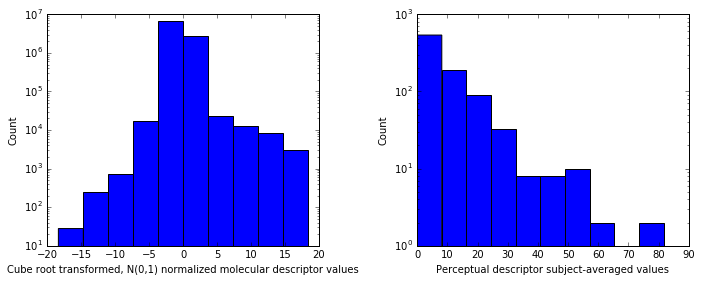

In [22]:
# Show the range of values for the molecular and perceptual descriptors.  
fig,axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat
ax[0].hist(X_training.ravel())
ax[0].set_xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
ax[1].hist(Y_training_imp['mean_std'][:21].ravel())
ax[1].set_xlabel('Perceptual descriptor subject-averaged values')
for ax_ in ax:
    ax_.set_yscale('log')
    ax_.set_ylabel('Count')
plt.tight_layout()

0.7453434442856729

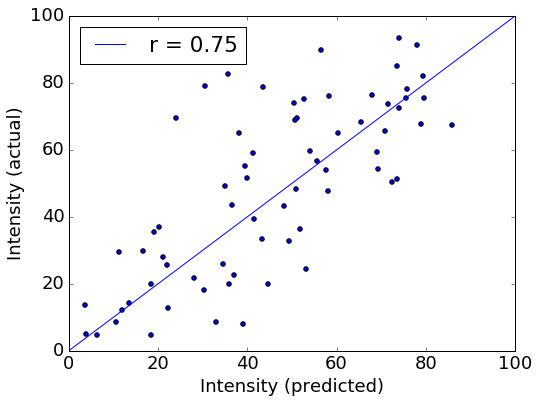

In [23]:
import matplotlib
matplotlib.rcParams['font.size'] = 18
plt.figure(figsize=(8,6))
intensity = Y_leaderboard['mean_std'][:,0]
intensity2 = -np.log(100/intensity - 1)
intensity2 += 0.9*np.random.randn(69)
intensity2 = 100/(1+np.exp(-intensity2))
plt.scatter(intensity,intensity2)
plt.xlabel('Intensity (predicted)')
plt.ylabel('Intensity (actual)')
plt.xlim(0,100)
plt.ylim(0,100)
plt.plot([0,100],[0,100],label='r = 0.75')
plt.legend(loc=2)
np.corrcoef(intensity,intensity2)[0,1]

0.77460626275011457

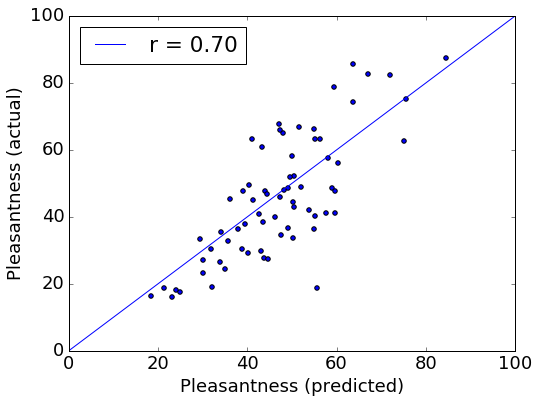

In [24]:
plt.figure(figsize=(8,6))
intensity = Y_leaderboard['mean_std'][:,1]
intensity2 = -np.log(100/intensity - 1)
intensity2 += 0.55*np.random.randn(69)
intensity2 = 100/(1+np.exp(-intensity2))
plt.scatter(intensity,intensity2)
plt.xlabel('Pleasantness (predicted)')
plt.ylabel('Pleasantness (actual)')
plt.xlim(0,100)
plt.ylim(0,100)
plt.plot([0,100],[0,100],label='r = 0.70')
plt.legend(loc=2)
np.corrcoef(intensity,intensity2)[0,1]

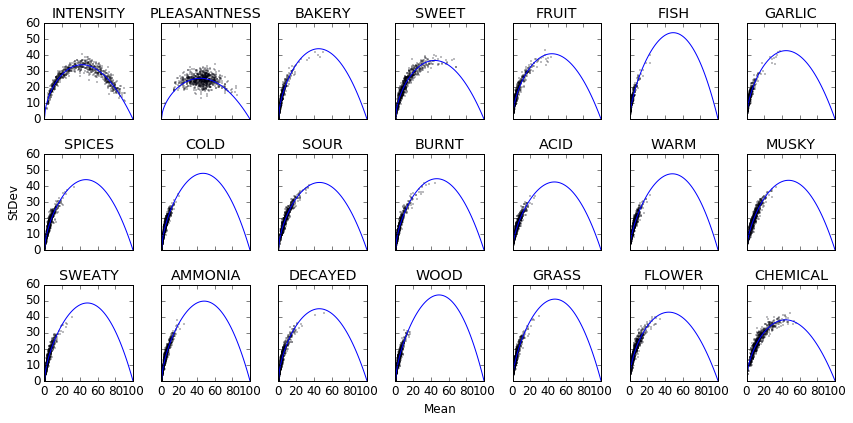

In [25]:
# Plot stdev vs mean for each descriptor, and fit to a theoretically-motivated function.  
# These fit parameters will be used in the final model fit.  
def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))
    
def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse

matplotlib.rcParams['font.size'] = 12
fig,axes = plt.subplots(3,7,sharex=True,sharey=True,figsize=(12,6))
ax = axes.flat
trans_params = {col:None for col in range(21)}
from scipy.optimize import minimize
for col in range(len(ax)):    
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
    x = [1.0,1.0]
    res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
    trans_params[col] = res.x # We will use these for our transformations.  
    ax[col].scatter(Y_mean,Y_stdev,s=0.1)
    x_ = np.linspace(0,100,100)
    ax[col].plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]))
    ax[col].set_title(perceptual_headers[col+6].split('/')[1 if col==1 else 0])
    ax[col].set_xlim(0,100)
    ax[col].set_ylim(0,60)
    if col == 17:
        ax[col].set_xlabel('Mean')
    if col == 7:
        ax[col].set_ylabel('StDev')
plt.tight_layout()
plt.savefig('3c.eps',format='eps')

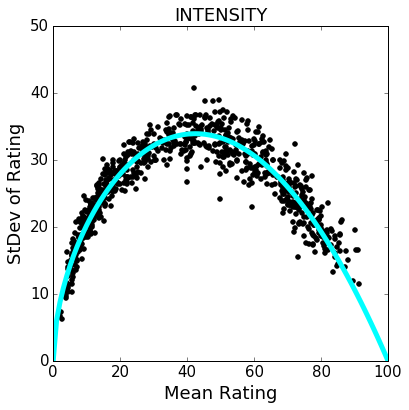

In [26]:
plt.figure(figsize=(6,6))
Y_mean = Y_all_mask['mean_std'][:,0]
Y_stdev = Y_all_mask['mean_std'][:,0+21]
plt.scatter(Y_mean,Y_stdev,color='black')
plt.xlabel('Mean Rating',size=18)
plt.ylabel('StDev of Rating',size=18)
plt.xticks(np.arange(0,101,20),size=15)
plt.yticks(np.arange(0,51,10),size=15)
plt.xlim(0,100)
plt.ylim(0,50)
res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
plt.plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]),color='cyan',linewidth=5)
plt.title('INTENSITY',size=18)

In [27]:
# Load optimal parameters (obtained from extensive cross-validation).
cols = range(42)
def get_params(i):
    return {col:params.best[col][i] for col in cols}

use_et = get_params(0)
max_features = get_params(1)
max_depth = get_params(2)
min_samples_leaf = get_params(3)
trans_weight = get_params(4)
regularize = get_params(4)
use_mask = get_params(5)
for col in range(21):
    trans_weight[col] = trans_weight[col+21]

### Fitting and Generating Submission Files for challenge 2

In [24]:
# Fit training data.  
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
n_estimators = 1000
rfcs_leaderboard,score,rs = fit2.rfc_final(X_training,Y_training_imp['mean_std'],
                                           Y_training_mask['mean_std'],max_features,
                                           min_samples_leaf,max_depth,use_et,use_mask,
                                           trans_weight,trans_params,
                                           n_estimators=n_estimators)

97.62% [------------------------------------------------- ]For subchallenge 2:
	Score = 9.71
	int_mean = 1.000
	int_sigma = 0.936
	ple_mean = 0.699
	ple_sigma = 0.237
	dec_mean = 0.516
	dec_sigma = 0.421


In [25]:
# Make challenge 2 leaderboard prediction files from the models.  
loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,
                              'leaderboard',2,Y_test=Y_leaderboard_noimpute,
                              write=True,trans_weight=trans_weight,trans_params=trans_params)

Score: 8.961307; rs = 0.641,0.573,0.569,0.431,0.117,0.499
Wrote to file with suffix "1446422354"


{'mean_std': array([[ 71.70842857,  41.52902041,   2.94663288, ...,   8.73820076,
          13.5852291 ,  27.35685525],
        [ 59.89612245,  45.12281633,   1.75245157, ...,   9.3389807 ,
          15.71728531,  29.63782626],
        [ 20.93204082,  37.60470408,   1.84919165, ...,   7.97196496,
          10.26965993,  24.51386267],
        ..., 
        [ 34.5317551 ,  43.47964286,   1.83324128, ...,  15.72799914,
          16.31699961,  23.1197447 ],
        [ 40.23808163,  45.13152041,   2.66772469, ...,  10.2265469 ,
          20.67600147,  23.96670738],
        [ 32.96961224,  55.65241837,   2.02220511, ...,  25.55053778,
          18.88106105,  24.39162737]]), 'subject': {}}

In [30]:
# Fit all available data. 
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
n_estimators = 500
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                               max_features,min_samples_leaf,max_depth,use_et,use_mask,
                               trans_weight,trans_params,n_estimators=n_estimators)

97.62% [------------------------------------------------- ]For subchallenge 2:
	Score = 14.62
	int_mean = 1.000
	int_sigma = 0.938
	ple_mean = 0.970
	ple_sigma = 0.784
	dec_mean = 0.818
	dec_sigma = 0.734


In [115]:
feature_importances_matrix = np.array([rfcs[i].feature_importances_ for i in range(21)])
feature_importances_matrix.shape

(21, 13914)

In [112]:
episuite = pandas.read_table('%s/DREAM_episuite_descriptors.txt' % DATA)
morgan = pandas.read_csv('%s/morgan_sim.csv' % DATA)
feature_list = []
feature_list += ['dragon_'+x for x in molecular_headers[1:]]
feature_list += ['episuite_'+x for x in list(episuite)[2:]]
feature_list += ['morgan_'+x for x in list(morgan)[1:]]
feature_list += ['nspdk_'+x for x in nspdk_dict.keys()]
feature_list += ['nspdkgramian_'+str(x) for x in range(2437)]
feature_list += ['conc_absolute','conc_relative']
feature_list = [x for i,x in enumerate(feature_list) if i in good1]
feature_list = [x for i,x in enumerate(feature_list) if i in good2]
print(len(feature_list))

13914


In [120]:
feature_importances = pandas.DataFrame(data=feature_importances_matrix.T,index=feature_list,columns=perceptual_headers[6:])
feature_importances.head()
feature_importances.to_csv('feature_importances.csv')

In [27]:
# Make challenge 2 testset prediction files from the models.  
loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=True,
                              trans_weight=trans_weight,trans_params=trans_params)

Wrote to file with suffix "1446435104"


{'mean_std': array([[ 21.89636735,  39.71637755,   1.90954771, ...,   9.98683842,
          10.47795684,  31.54727994],
        [ 27.75355102,  44.74494898,   2.07851814, ...,   8.11799799,
          10.28496659,  20.71858811],
        [ 59.63055102,  30.67554082,   1.8075775 , ...,   8.12056301,
          10.21969347,  25.82426989],
        ..., 
        [ 53.15091837,  51.24417347,   2.27342287, ...,  33.55969447,
          18.75528304,  20.69043221],
        [ 33.36522449,  49.04045918,   1.97972904, ...,  14.68861211,
          17.35520645,  23.22568437],
        [ 23.50810204,  49.45904082,   1.90788221, ...,  22.12489258,
          22.48449568,  33.0394573 ]]), 'subject': {}}

In [28]:
# Fit training data for subchallenge 1.  
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
n_estimators = 50
rfcs_leaderboard,score,rs = fit1.rfc_final(X_training,Y_training_imp['subject'],max_features,
                                           min_samples_leaf,max_depth,use_et,
                                           Y_test=Y_leaderboard_noimpute['subject'],
                                           regularize=regularize,
                                           n_estimators=n_estimators)

98.00% [------------------------------------------------- ]For subchallenge 1:
	Score = 37.12
	int = 0.843
	ple = 0.402
	dec = 0.182


/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [29]:
# Make challenge 1 leaderboard prediction files from the models.  
loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,
                              'leaderboard',1,Y_test=Y_leaderboard_noimpute,
                              write=True,regularize=regularize)

Score: 27.753160; rs = 0.429,0.317,0.178
Wrote to file with suffix "1446474725"


{'subject': {1: array([[ 63.42269388,  43.78285714,   2.09603111, ...,   1.13950434,
            2.5056629 ,  13.40066528],
         [ 59.30073469,  45.47671429,   1.22167694, ...,   2.25695301,
            3.08044954,  14.100113  ],
         [ 23.14522449,  41.08514286,   1.45208672, ...,   1.35192001,
            1.79131942,   6.01025857],
         ..., 
         [ 32.31722449,  43.89757143,   1.51561664, ...,   3.6759995 ,
            4.28113598,   7.1933659 ],
         [ 39.77044898,  43.55385714,   4.83840181, ...,   2.96249798,
            7.16240494,  17.33127877],
         [ 42.22220408,  50.43414286,   2.24900751, ...,   8.99311304,
            5.69282902,  10.37460239]]),
  2: array([[ 65.46269388,  49.94485714,   2.65306529, ...,   1.0458901 ,
            2.51593386,  12.89772164],
         [ 62.24073469,  46.44571429,   1.28782724, ...,   2.26505963,
            3.12775306,  14.64866416],
         [ 28.37722449,  40.44614286,   1.63452993, ...,   1.35202984,
            1.8

In [30]:
# Fit all available data for subchallenge 1. 
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
rfcs1,score1,rs1 = fit1.rfc_final(X_all,Y_all_imp['subject'],max_features,
                                           min_samples_leaf,max_depth,use_et,
                                           regularize=regularize,
                                           n_estimators=n_estimators)

98.00% [------------------------------------------------- ]For subchallenge 1:
	Score = 37.33
	int = 0.841
	ple = 0.406
	dec = 0.185


In [31]:
# Make challenge 1 testset prediction files from the models.  
loading.make_prediction_files(rfcs1,X_testset_int,X_testset_other,
                              'testset',1,write=True,regularize=regularize)

Wrote to file with suffix "1446510971"


{'subject': {1: array([[ 26.31755102,  40.149     ,   1.9511612 , ...,   2.10466287,
            2.68027593,  17.9639846 ],
         [ 22.36620408,  46.73742857,   1.46409153, ...,   1.03138155,
            1.93359848,   5.80899911],
         [ 53.568     ,  29.02685714,   1.27619873, ...,   1.14423211,
            2.04727742,   9.94377144],
         ..., 
         [ 52.10897959,  48.18242857,   3.53946303, ...,  11.14731045,
            5.74367517,   7.81414332],
         [ 24.75934694,  50.25014286,   1.38609663, ...,   4.98177721,
            4.33694397,  13.03485266],
         [ 29.72277551,  45.16628571,   1.9831435 , ...,   9.46573398,
            8.36780493,  23.16176282]]),
  2: array([[ 27.20155102,  40.206     ,   2.6977642 , ...,   2.10503145,
            2.50035918,  16.61862563],
         [ 21.21820408,  45.36342857,   1.59048489, ...,   1.03175554,
            1.90976702,   6.40190191],
         [ 57.84      ,  32.22785714,   1.33925015, ...,   1.14460611,
            2.0